# Categorizing Documents with Similarity Scores
The task is to identify the most relevant working group for each instance of feedback collected by OMB's Federal Data Strategy Group. Each instance of feedback and each of the four working groups is represented by a string description. Relevancy between instance-working-group combinations will be calculated using a similarity score after each textual element has been vectorized using word embeddings.

The output is a spreadsheet containing all of the feedback instances along with similarity scores for each of the four working groups:
 - Enterprise Data Governance 
 - Access, Use and Augmentation 
 - Decision-Making and Accountability
 - Commercialization, Innovation, and Public Use 
 
The higher the similarity score, the more relevant the working group.

In [1]:
import pandas as pd
import numpy as np
from spacy.lang.en import English
import nltk
from nltk.corpus import wordnet as wn
import gensim
import pyLDAvis.gensim
from bs4 import BeautifulSoup
from nltk.tokenize.toktok import ToktokTokenizer
import enchant
import contractions
import re
from nltk.tokenize import word_tokenize
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.preprocessing import StandardScaler
import warnings
from collections import defaultdict
from sklearn.metrics.pairwise import cosine_similarity, polynomial_kernel
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
%matplotlib inline
warnings.filterwarnings('ignore')

/anaconda/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/anaconda/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192, got 176
  return f(*args, **kwds)
/anaconda/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/anaconda/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192, got 176
  return f(*args, **kwds)
/anaconda/lib/python3.6/site-packages/requests/__init__.py:91: RequestsDependencyWarning: urllib3 (1.23) or chardet (2.3.0) doesn't match a supported version!
  RequestsDependencyWarning)


In [3]:
data = pd.read_excel(r'Federal Data Strategy Comments.xlsx',usecols=[1])
keywords = pd.read_excel('Working_Group_Terms.xlsx')

# 1. Inspect the Data
Here, we'll visualy inspect the data to get a feel for it.

### The Feedback

In [4]:
pd.set_option('max_colwidth',150)
data.head()

,Instance
0,"I work as part of the team behind DataUSA.io, an open data visualization website which relies heavily on data from federal government sources (e.g..."
1,"#3 has 5 verbs\n\n#4 has 4 verbs, 2 adverbs, and 7 nouns and is basically a reiteration of OMB Circular A-130 and all the laws it implements.\n\n#..."
2,"Integrate LEHD Data with Local/Regional Transportation data to develop more robust and timely ""Access to Jobs"" metrics. \n\nFor example: a low-inc..."
3,"Previous engagement on government technology and data policy has occurred on GitHub -- with both the code and content available to all, and the fe..."
4,"It is noticeable that there are no mentions of open data among the strategic principles, as this has been a strong aspect of previous U.S. governm..."


In [5]:
data.shape

(604, 1)

In [6]:
data.isnull().sum()

Instance    0
dtype: int64

# The Working Groups
There are $4$ working groups:
 - Enterprise Data Governance
 - Access, Use and Augmentation
 - Decision-Making and Accountability
 - Commercialization, Innovation, and Public Use

Each of the $4$ working groups has a number of topics within it. Each of these topics then has a description. Our task is to assign comments to each of the working groups based on how similar the comment is to each working group's description.

In [7]:
keywords.head()

,Topic,Description,WG1,WG2,WG3,WG4
0,Data Governance:,"Data Governance ensures that data assets are formally managed. A data governance model for the federal government establishes clarity, agreement a...",x,NaN,NaN,NaN
1,Data Governance: Communications,"is the process of using computing and communication technologies to transfer data from one place to another, and vice versa. It enables the moveme...",x,NaN,NaN,NaN
2,Data Governance: Data Handling Ethics,in an ethical manner is necessary to the long-term success of any organization that wants to get value from its data.,x,NaN,NaN,NaN
3,Data Governance: Data Principles & Policies,"fundamental rules governing the creation, acquisition, management, integrity, security, quality, and use of data and information",x,NaN,NaN,NaN
4,Data Governance: Issues Management,"is a process of removing or reducing the impact of obstacles that prevent effective use of data. Issue management includes identification, definit...",x,NaN,NaN,NaN


In [8]:
keywords.shape

(96, 6)

In [9]:
keywords.isnull().sum()

Topic           1
Description    16
WG1            64
WG2            51
WG3            55
WG4            80
dtype: int64

# 2. Cleaning and Normalizing the Text
In this step, we want to clean the text so that it only includes meaningful information. That means we need to:
 - strip html tags
 - strip urls
 - strip email addresses
 - strip nonsensical words that include numbers in them or are more than 17 characters long
 - expand contractions (e.g. can't becomes cannot)
 - strip misspellings (optional)
 - tokenize the text

In [10]:
def clean(doc, spellcheck=True):
    
    en_stop = set(nltk.corpus.stopwords.words('english'))
    tokenizer = ToktokTokenizer()
    
    def strip_html_tags(text):
        soup = BeautifulSoup(text, "html.parser")
        stripped_text = soup.get_text()
        return stripped_text

    def strip_urls(text):
        #url regex
        url_re = re.compile(r"""(?i)\b((?:https?://|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}/)(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:'".,<>?«»“”‘’]))""")
        stripped_text = url_re.sub('',text)
        return stripped_text

    def strip_emails(text):
        #email address regex
        email_re = re.compile(r'(^[a-zA-Z0-9_.+-]+@[a-zA-Z0-9-]+\.[a-zA-Z0-9-.]+$)')
        stripped_text = email_re.sub('',text)
        return stripped_text

    def strip_nonsense(text):
        # leave words that are at least three characters long, do not contain a number, and are no more 
        # than 17 chars long
        no_nonsense = re.findall(r'\b[a-z][a-z][a-z]+\b',text)
        stripped_text = ' '.join(w for w in no_nonsense if w != 'nan' and len(w) <= 17)
        return stripped_text

    def expand_contractions(text, contraction_mapping=contractions.contractions_dict):

            contractions_pattern = re.compile('({})'.format('|'.join(contraction_mapping.keys())),
                                              flags=re.IGNORECASE|re.DOTALL)
            def expand_match(contraction):
                match = contraction.group(0)
                first_char = match[0]
                if contraction_mapping.get(match):
                    expanded_contraction = contraction_mapping.get(match)
                else:
                    expanded_contraction = contraction_mapping.get(match.lower())
                if expanded_contraction:
                    expanded_contraction = first_char+expanded_contraction[1:]
                    return expanded_contraction
                else:
                    pass

            expanded_text = contractions_pattern.sub(expand_match, text)
            expanded_text = re.sub("'", "", expanded_text)
            return expanded_text

    def strip_misspellings(text):
        d = enchant.Dict("en_US")
        words_to_add = ['api','git','github','apis']
        for w in words_to_add:
            d.add(w)
        
        
        tokens = tokenizer.tokenize(text)
        non_dict_words = set([word for word in tokens if d.check(word) is False and re.match('^[a-zA-Z ]*$',word)])
        stripped_text = " ".join([x for x in tokens if x not in non_dict_words])
        return stripped_text
    
    doc = doc.lower()
    doc = " ".join([word for word in tokenizer.tokenize(doc) if word not in en_stop])
    contraction_free = expand_contractions(doc)
    tag_free = strip_html_tags(contraction_free)
    url_free = strip_urls(tag_free)
    email_free = strip_emails(url_free)
    if spellcheck:
        misspelling_free = strip_misspellings(email_free)
        normalized = strip_nonsense(misspelling_free)

    else:
        normalized = strip_nonsense(email_free)
    
    return normalized

## 2.1 Clean the Feedback Instances
Below, we'll `apply` the cleaning function to the feedback column in the spreadsheet.

In [11]:
# this is a crude, time-consuming approach TODO: simplify/optimize
instance_corpus = data['Instance'].apply(lambda x: clean(x))

Here's the first comment before the cleaning:

In [12]:
print(data['Instance'].iloc[0])

I work as part of the team behind DataUSA.io, an open data visualization website which relies heavily on data from federal government sources (e.g. Census, BLS, BEA, CDC). I'm glad to see principle #4 reference interoperability, because that has been one of our biggest challenges as users of federal data. In particular around consistent use of standard classification systems (for industries, occupations, courses of study, products etc). Many times agencies will talk about the same types of things but will use slightly different coding schemes that deviate from the standard classification systems. Working to find ways to preserve privacy while also maintaining adherence to standard classification systems is vital to users that are trying to inter-link datasets and unlock the full potential of the data.


And here's that same comment after the cleaning:

In [13]:
print(instance_corpus[0])

work part team behind datausa open data visualization website relies heavily data federal government sources census glad see principle reference interoperability one biggest challenges users federal data particular around consistent use standard classification systems industries occupations courses study products etc many times agencies talk types things use slightly different coding schemes deviate standard classification systems working find ways preserve privacy also maintaining adherence standard classification systems vital users trying inter link datasets unlock full potential data


## 2.2 Clean the Keywords

In [14]:
# first concatenate the topic to its description
keywords['Text'] = keywords['Topic'].fillna(value = "").astype(str) +\
                   " " + keywords['Description'].fillna(value = "").astype(str)

In [15]:
# clean this concatenated text, replacing np.nan with empty strings
keywords['Clean Text'] = keywords['Text'].apply(lambda x: clean(x))
keywords['Clean Text'].replace(r'',np.nan,regex=False,inplace=True)

In [16]:
keyword_corpus = keywords['Clean Text']

Here's a working group topic description before the cleaning:

In [17]:
print(keywords['Text'].iloc[6])

Data Governance: Operating Framework clarifies, and establishes, and executes agreements over the specification of decision rights, accountability frameworks, and data management standards, in order to encourage standardized data management during the data lifecycle.


And here's that same text after the cleaning:

In [18]:
keyword_corpus[6]

'data governance operating framework clarifies establishes executes agreements specification decision rights accountability frameworks data management standards order encourage standardized data management data'

## 2.3 Combine the Corpora
In this step, we'll combine the keyword and feedback corpora into a single corpus. We'll use this later.

In [19]:
# Make a Combined Corpus
corpus = pd.concat([keyword_corpus,instance_corpus]).dropna()

# 3. Text Vectorization
You can't do math with letters, so you need a way to convert words into numbers. This process is called vectorizatio.

In Natural Language Processing (NLP), there's a variety of methods that map words into vectors that contains numeric values so that machines can do math with those vectors. We'll look at two methods below.

## 3.1 The Traditional Text Vectorization Approach
The traditional method of representing words as vectors is to **one-hot encode** them. In this process, the length of the vector is equal to the size of the total unique vocabulary in the corpora. Conventionally, these unique words are encoded in alphabetical order. Namely, you should expect the one-hot vectors for words starting with “a” with target “1” of lower index, while those for words beginning with “z” with target “1” of higher index.

<img src="https://cdn-images-1.medium.com/max/1600/1*ULfyiWPKgWceCqyZeDTl0g.png" height = 450 width=450>

Although this vectorization is simple and easy to implement, there are several issues:
 - you cannot infer relationships between two words. For instance, although the words “endure” and “tolerate”, have similar meanings, their targets “1” are far from each other within each word's vector. 
 - the vectors are very sparse, as there are numerous redundant 0's in the vectors. This means that we are wasting a lot of space in memory.

## 3.2 Word Embeddings
A **word embedding** is a type of mapping that allows words with similar meanings to have similar vector representations. A key assumption in this mapping is the **distributional hypothesis**, which states that words with similar meanings will occur with similar neighbors.

Creating a word embedding involves training a neural network to learn the surrounding words that represent every target word within a corpus.

The vectors returned by this neural network can then mathematically describe the relationship between words. The vectors obtained by subtracting two related words sometimes express a meaningful concept such as gender or verb tense, as shown in the following figure (dimensionality reduced).

<img src="https://www.tensorflow.org/images/linear-relationships.png" height=500 width=800>

## 3.3 Create Word Embeddings for the Comments

In [20]:
tokens = [word_tokenize(s) for s in corpus]
#### Create Fast Text Model ####
# Set values for various parameters
print("="*80)
print("Learning word embeddings using the FastText Model...")
feature_size = 300    # Word vector dimensionality
window_context = 50   # Context window size
min_word_count = 3    # Minimum word count
sample = 1e-3         # Downsample setting for frequent words

ft_model = gensim.models.fasttext.FastText(tokens, size=feature_size, window=window_context,
                                           min_count=min_word_count,sample=sample, sg=1, iter=50)
ft_embedding = {w: vec for w, vec in zip(ft_model.wv.vocab.keys(), ft_model.wv.vectors)}
print("\tDone learning word embeddings using the FastText Model.")
print("_"*80)

Learning word embeddings using the FastText Model...
	Done learning word embeddings using the FastText Model.
________________________________________________________________________________


Now that we've trained a word embedding model on our corpus, let's see the vector representation for the word `privacy`:

In [21]:
print(ft_embedding['privacy']) 

[ 0.15132828  0.02029222  0.01786475  0.25283185 -0.03917486  0.12799788
  0.08950055  0.12108936  0.09062934 -0.25107852  0.01070699  0.04959331
  0.21600719 -0.06086767 -0.08672404 -0.10897539 -0.12762794  0.11744515
  0.03871953 -0.2254867  -0.48760262 -0.11121111 -0.16992103 -0.17141436
 -0.5840545  -0.30030853  0.36021912 -0.12021217  0.39940685 -0.27369046
 -0.17695956  0.16677961  0.23014732  0.30586562  0.19671768 -0.27680472
 -0.4058172  -0.05920848 -0.07532392  0.42110482 -0.17636825  0.04961498
 -0.18312755  0.15576707 -0.08817371 -0.11760711 -0.03076152  0.38899297
 -0.3006116  -0.05366548 -0.04566906  0.07428943 -0.32678893  0.13739768
 -0.12024488 -0.05655747  0.27413812  0.20844308 -0.00129339 -0.08231981
  0.03263489 -0.07868057  0.23347257  0.24552996 -0.25580892 -0.44712627
 -0.08145075  0.09248609 -0.22897635  0.11709151  0.09525267 -0.6060213
  0.5456053   0.23342383 -0.3132998  -0.35040933 -0.08005612  0.22636233
  0.30704     0.16314673 -0.216378   -0.1393235  -0.

### 3.3.1 Finding Similar Words
Let's see the words that are "closest" to `privacy`:

In [22]:
# We will also need to get the words closest to a word
ft_model.similar_by_word('privacy')

[('security', 0.5754725933074951),
 ('protecting', 0.4895274043083191),
 ('confidentiality', 0.4804401993751526),
 ('protections', 0.4253268837928772),
 ('balances', 0.38053423166275024),
 ('checks', 0.3802436590194702),
 ('protection', 0.36849451065063477),
 ('rights', 0.3631744682788849),
 ('concerns', 0.3385086953639984),
 ('personal', 0.33178526163101196)]

### 3.3.2 Visualizing Similar Words
Each word has a vector of 300 mapped to it. We can use a technique called [t-distributed Stochastic Neighbor Embedding (TSNE)](http://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html) to visualize this high-dimensional data in 2 dimensions.

The function below will take a word, such as `confidentiality`, find its most similar words, reduce each of those words' vectors into a 2-dimensional space using TSNE, and then plot the results. 

In [23]:
def display_closestwords_tsnescatterplot(model, word):
    arr = np.empty((0,300), dtype='f')
    word_labels = [word]

    # get close words
    close_words = model.similar_by_word(word)
    
    # add the vector for each of the closest words to the array
    arr = np.append(arr, np.array([model[word]]), axis=0)
    for wrd_score in close_words:
        wrd_vector = model[wrd_score[0]]
        word_labels.append(wrd_score[0])
        arr = np.append(arr, np.array([wrd_vector]), axis=0)
        
    # find tsne coords for 2 dimensions
    tsne = TSNE(n_components=2, random_state=0)
    np.set_printoptions(suppress=True)
    Y = tsne.fit_transform(arr)

    x_coords = Y[:, 0]
    y_coords = Y[:, 1]
    # display scatter plot
    plt.scatter(x_coords, y_coords)

    for label, x, y in zip(word_labels, x_coords, y_coords):
        plt.annotate(label, xy=(x, y), xytext=(0, 0), textcoords='offset points')
    plt.xlim(x_coords.min()+50, x_coords.max()+50)
    plt.ylim(y_coords.min()+50, y_coords.max()+50)
    plt.show()

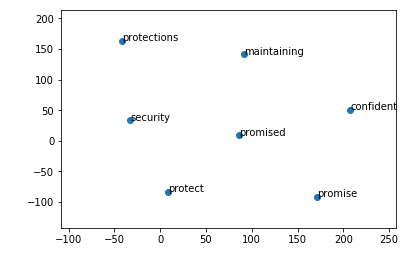

In [24]:
display_closestwords_tsnescatterplot(ft_model, 'confidentiality')

# 4. Aggregating Word Embeddings
Now that we know how to vectorize a single word, we need a way to aggregate the vectors of every word in a given comment. This will give us a single vector for each comment instead of one vector for each word within a comment.

## 4.1 TF-IDF Mean Aggregation
A better, albeit more complicated, approach is to calculate a weighted average. Below, we'll **term-frequnecy inverse document frequency (tf-idf)** scores to weight each word's vector before calculating the mean.
>**term-frequency inverse document frequency (tf-idf)**:  Tf-idf stands for term frequency-inverse document frequency, and the tf-idf weight is a weight often used in information retrieval and text mining. This weight is a statistical measure used to evaluate how important a word is to a document in a collection or corpus. The importance increases proportionally to the number of times a word appears in the document but is offset by the frequency of the word in the corpus. Variations of the tf-idf weighting scheme are often used by search engines as a central tool in scoring and ranking a document's relevance given a user query

To calculate this for all of our comments and working group text, we define the following class:

In [28]:
class TfidfEmbeddingVectorizer(BaseEstimator, TransformerMixin):
    """
    Description:
        This class is designed for use as a transformer within a sklearn pipeline. The pipeline will call
        the fit and transform instance methods.

        The class attributes instantiate the fastext word embedding model.
        This model makes a dictionary mapping unique words from the entire corpus to vectors of shape [300,].
        The transform method uses tf-idf weighting to aggregate each word vector at the doc level.
    """

    def __init__(self, corpus):
        """
        Description:
            Create an instance of the class with the chosen model.

        Arguments:
            None

        """
        # let tokens be a list of tokenized texts (i.e. list of lists of tokens)
        tokens = [word_tokenize(s) for s in corpus]

        #### Create Fast Text Model ####
        # Set values for various parameters
        print("="*80)
        print("Learning word embeddings for FastText Model...")
        feature_size = 300    # Word vector dimensionality
        window_context = 50   # Context window size
        min_word_count = 3    # Minimum word count
        sample = 1e-3         # Downsample setting for frequent words

        ft_model = gensim.models.fasttext.FastText(tokens, size=feature_size, window=window_context,
                                                   min_count=min_word_count,sample=sample, sg=1, iter=50)
        ft_embedding = {w: vec for w, vec in zip(ft_model.wv.vocab.keys(), ft_model.wv.vectors)}
        print("\tDone learning word embeddings for FastText Model.")
        print("_"*80)

        self.model = ft_embedding
        self.dim = len(next(iter(self.model.values())))
        self.word2weight = None


    def fit(self, X_train, y=None):
        """
        Description:
            When this method is called by the sklearn pipeline, it creates the tf_idf scores for the words.
            These will be used by transform as weights when aggregating the vector representations of each
            word at the instance level.

        """
        # pass callable to analyzer to extract the sequence of features out of the instance.
        tfidf = TfidfVectorizer(analyzer=lambda x: x)
        tfidf.fit(X_train)
        # if a word was never seen - it must be at least as infrequent
        # as any of the known words - so the default idf is the max of
        # known idf's
        max_idf = max(tfidf.idf_)
        self.word2weight = defaultdict(lambda: max_idf,[(w, tfidf.idf_[i]) for w, i in tfidf.vocabulary_.items()])
        return self



    def transform(self, X_train):
        instances  = [[word for word in instance.split(" ")] for instance in X_train]
        embeddings =  np.array([np.mean([self.model[w] * self.word2weight[w]
                                         for w in words if w in self.model] or
                        [np.zeros(self.dim)], axis=0) for words in instances]).astype('float')
        return embeddings

This class will implement all of the word vectorization steps for us. First, we'll retrain our word embedding model on the entire corpus:

In [29]:
#instantiate model
vec = TfidfEmbeddingVectorizer(corpus = corpus)

Learning word embeddings for FastText Model...
	Done learning word embeddings for FastText Model.
________________________________________________________________________________


Then we'll apply the word embedding model to the instance and keyword corpora separately. 

Since we're going to do math with these vectors, we'll include another step that standardizes the vectors by removing the mean and scaling to unit variance. This step is a common requirement for many algorithms as they might behave poorly if the vectors do not more or less look like standard normally distributed data.

In [30]:
#get the word embeddings for each instance
X = instance_corpus
vec.fit(X)
X_vec = vec.transform(X)
#scale
scaler = StandardScaler()
X_vec_scaled = scaler.fit_transform(X_vec)


#get the word embeddings for each working group
melted_keywords = pd.melt(keywords[['Clean Text','WG1','WG2','WG3','WG4']],id_vars='Clean Text').dropna().drop(labels='value',axis=1)
wg_df = melted_keywords.groupby(by='variable')['Clean Text'].apply(lambda x: " ".join(x))
y = wg_df.values
vec.fit(y)
y_vec = vec.transform(y)
#scale
scaler = StandardScaler()
y_vec_scaled = scaler.fit_transform(y_vec)

# 5. Calculating Similarity between a Comment and a Working Group
Now that we've got vector representations of each working group and each instance of feedback, we can calculate the **cosine similairty** between an instance of feedback and each working group. 
>**cosine similarity**: this computes the L2-normalized dot product of vectors. That is, if $x$ and $y$ are row vectors, their cosine similarity $k$ is defined as:
$$k(x, y) = \frac{x y^\top}{\|x\| \|y\|}$$
This is called cosine similarity because Euclidean (L2) normalization projects the vectors onto the unit sphere, and their dot product is then the cosine of the angle between the points denoted by the vectors.

We can calculate the cosine similarity very easily in Python:

In [31]:
d_cos = cosine_similarity(X_vec_scaled,y_vec_scaled)

Above, we returned a kernel matrix, which is an array with shape (n_samples_x, n_samples_x). We had 604 comments and 4 working groups, so the `shape` of d_cos should be $(604,4)$:

In [32]:
d_cos.shape

(604, 4)

Each row in this matrix represents and instance of feedback, and each column represents a working group. The values are the cosine similarity scores. Let's convert this array to a pandas dataframe to see:

In [33]:
pd.DataFrame(d_cos).head()

,0,1,2,3
0,0.010772,-0.055226,-0.094894,0.103237
1,0.096053,-0.107179,-0.061559,0.014675
2,-0.043883,0.068102,0.043570,-0.033022
3,0.136334,-0.168094,-0.052018,0.004485
4,0.187178,-0.154060,-0.217363,0.065685


The scores range from $−1$, meaning exactly opposite, to $1$ meaning exactly the same. $0$ indicates orthogonality or decorrelation, while in-between values indicate intermediate similarity or dissimilarity.

Since our task is to find the most similar working group for each instance of feedback, we want to find the max column value for each row. Let's do that:

In [34]:
max_values = np.amax(d_cos,axis=1)
max_indices = np.argmax(d_cos,axis=1)
max_cos = list(zip(max_indices,max_values))

# 6. Create a Spreadsheet of the Results
Since the end-user doesn't know Python and wouldn't want to share these results via a Jupyer Notebook, we can write our results to a user-friendly Excel spreadsheet.

In [35]:
wg_name_map = {0:'Enterprise Data Governance',
               1:'Access, Use and Augmentation',
               2:'Decision-Making and Accountability',
               3:'Commercialization, Innovation, and Public Use'}

data['Recommended Working Group'] = np.nan
data['Recommended Working Group Similarity Score'] = np.nan

data[['Recommended Working Group','Recommended Working Group Similarity Score']] = max_cos
data['Recommended Working Group'] = data['Recommended Working Group'].map(wg_name_map)

data['Enterprise Data Governance Similarity Score'] = np.nan
data['Access, Use and Augmentation Similarity Score'] = np.nan
data['Decision-Making and Accountability Similarity Score'] = np.nan
data['Commercialization, Innovation, and Public Use Similarity Score'] = np.nan
data[['Enterprise Data Governance Similarity Score',
      'Access, Use and Augmentation Similarity Score',
      'Decision-Making and Accountability Similarity Score',
      'Commercialization, Innovation, and Public Use Similarity Score']] = d_cos

writer = pd.ExcelWriter('Instances Mapped to Working Groups.xlsx')
data.to_excel(writer,'Sheet1',index=False)
writer.save()

## 6.1 Inspect the Results
Below, we'll check out one of the feedback instances and see which working group it got mapped to.

In [40]:
data.head()

,Instance,Recommended Working Group,Recommended Working Group Similarity Score,Enterprise Data Governance Similarity Score,"Access, Use and Augmentation Similarity Score",Decision-Making and Accountability Similarity Score,"Commercialization, Innovation, and Public Use Similarity Score"
0,"I work as part of the team behind DataUSA.io, an open data visualization website which relies heavily on data from federal government sources (e.g...","Commercialization, Innovation, and Public Use",0.103237,0.010772,-0.055226,-0.094894,0.103237
1,"#3 has 5 verbs\n\n#4 has 4 verbs, 2 adverbs, and 7 nouns and is basically a reiteration of OMB Circular A-130 and all the laws it implements.\n\n#...",Enterprise Data Governance,0.096053,0.096053,-0.107179,-0.061559,0.014675
2,"Integrate LEHD Data with Local/Regional Transportation data to develop more robust and timely ""Access to Jobs"" metrics. \n\nFor example: a low-inc...","Access, Use and Augmentation",0.068102,-0.043883,0.068102,0.043570,-0.033022
3,"Previous engagement on government technology and data policy has occurred on GitHub -- with both the code and content available to all, and the fe...",Enterprise Data Governance,0.136334,0.136334,-0.168094,-0.052018,0.004485
4,"It is noticeable that there are no mentions of open data among the strategic principles, as this has been a strong aspect of previous U.S. governm...",Enterprise Data Governance,0.187178,0.187178,-0.154060,-0.217363,0.065685
